In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/Jianf-Wang/GRCNN

import sys
sys.path.append('/content/GRCNN/')

Cloning into 'GRCNN'...
remote: Enumerating objects: 1463, done.
remote: Counting objects: 100% (243/243), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 1463 (delta 132), reused 235 (delta 124), pack-reused 1220
Receiving objects: 100% (1463/1463), 12.38 MiB | 1.83 MiB/s, done.
Resolving deltas: 100% (558/558), done.


In [82]:
import os
import json
import torch
from torch.utils.data import Dataset
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
from tqdm import tqdm

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, "images")
        self.label_dir = os.path.join(root_dir, "labels")
        self.transform = transform

        self.image_files = sorted([f for f in tqdm(os.listdir(self.image_dir), desc="Loading Images") if f.endswith('.jpg')])

        self.label_map = {
            "car": 0,
            "truck": 1,
            "bus": 2,
            "special_vehicle": 3,
            "motorcycle": 4,
            "bicycle": 5,
            "pedestrian": 6,
            "traffic_sign": 7,
            "traffic_light": 8,
            "none": 9
        }

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.image_dir, self.image_files[idx])
        label_path = img_path.replace("images", "labels").replace(".jpg", ".json")

        image = Image.open(img_path).convert("RGB")
        orig_width, orig_height = image.size

        if self.transform:
            image = self.transform(image)

        with open(label_path, 'r') as file:
            label_data = json.load(file)

        boxes = [anno['Coordinate'] for anno in label_data['Annotation']]
        labels = [anno['Label'] for anno in label_data['Annotation']]

        new_width, new_height = (224, 224)
        width_ratio = new_width / orig_width
        height_ratio = new_height / orig_height

        # Convert boxes to [x1, y1, x2, y2] format
        boxes = [[box[0] * width_ratio, box[1] * height_ratio, (box[0] + box[2]) * width_ratio, (box[1] + box[3]) * height_ratio] for box in boxes]

        # Convert string labels to integer labels
        labels = [self.label_map[label] for label in labels]
        labels_tensor = torch.tensor(labels, dtype=torch.int64)

        # Create the target dictionary
        sample = {
            'data': image,
            'labels': {
                "boxes": torch.tensor(boxes, dtype=torch.float32),
                "labels": labels_tensor
            }
        }

        return sample


In [204]:
# 데이터 로더 생성
from torch.utils.data import DataLoader

transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
def custom_collate(batch):
    data = [item['data'] for item in batch]
    labels = [item['labels'] for item in batch]

    return {'data': torch.stack(data), 'labels': labels}

train_dataset = CustomDataset(root_dir="/content/drive/MyDrive/data/2DB/training", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, collate_fn=custom_collate)

val_dataset = CustomDataset(root_dir="/content/drive/MyDrive/data/2DB/validation", transform=transform)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0, collate_fn=custom_collate)

test_dataset = CustomDataset(root_dir="/content/drive/MyDrive/data/2DB/test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0, collate_fn=custom_collate)

Loading Images: 100%|██████████| 100/100 [00:00<00:00, 639375.61it/s]


In [205]:
import torch.optim as optim
import torch
from torch.nn import init
import GRCNN.models.imagenet.GRCNN as grcnn
from tqdm import tqdm

class ExtendedGRCNN(torch.nn.Module):
    def __init__(self, base_model, num_classes, max_objects=20):
        super(ExtendedGRCNN, self).__init__()

        self.base_model = base_model
        self.max_objects = max_objects

        # Extracting the number of features before the classifier
        num_features = base_model.classifier.in_features

        # Classification head
        self.classifier_layer = torch.nn.Linear(num_features, max_objects * num_classes)

        # Regression head for bounding box prediction
        self.bbox_layer = torch.nn.Linear(num_features, max_objects * 4)

        # Initialize weights
        init.kaiming_normal_(self.classifier_layer.weight)
        init.zeros_(self.classifier_layer.bias)
        init.kaiming_normal_(self.bbox_layer.weight)
        init.zeros_(self.bbox_layer.bias)

    def forward(self, x):
    # Extract features
      features = self.base_model.avgpool(
          self.base_model.lastact(
              self.base_model.layer4(
                  self.base_model.layer3(
                      self.base_model.layer2(
                          self.base_model.layer1(
                              self.base_model.conv2(
                                  self.base_model.maxpool(
                                      self.base_model.relu(
                                          self.base_model.bn1(
                                              self.base_model.conv1(x)
                                          )
                                      )
                                  )
                              )
                          )
                      )
                  )
              )
          )
      )
      features = features.view(features.size(0), -1)

      # Predictions
      class_probs = self.classifier_layer(features).view(-1, max_objects, num_classes)
      bbox_coords = self.bbox_layer(features).view(-1, max_objects, 4)

      return {
          'class_probs': class_probs,
          'bbox_coords': bbox_coords
      }


device = 'cpu'
# Load the pre-trained state_dict
pretrained_state_dict = torch.load('/content/drive/MyDrive/models/checkpoint_params_grcnn55.pt')

# Instantiate your model
base_model = grcnn.grcnn55(10)

# Filter out unnecessary keys
filtered_state_dict = {k: v for k, v in pretrained_state_dict.items() if k in base_model.state_dict() and base_model.state_dict()[k].shape == v.shape}

# Overwrite entries in the existing state_dict
base_model_state_dict = base_model.state_dict()
base_model_state_dict.update(filtered_state_dict)

# Load the new state_dict into the base_model
base_model.load_state_dict(base_model_state_dict)

# Instantiate your extended model using the base_model
extended_grcnn = ExtendedGRCNN(base_model, num_classes=10, max_objects=30).to(device)

# Placeholder loss. Replace with appropriate detection loss.
criterion = torch.nn.BCEWithLogitsLoss()

# Adjust this to train the extended model
optimizer = optim.SGD(extended_grcnn.parameters(), lr=0.01, momentum=0.9)


In [206]:
def one_hot_encode(labels, num_classes=10):
    one_hot = torch.zeros(labels.size(0), num_classes)
    for i, label in enumerate(labels):
        one_hot[i, label] = 1
    return one_hot

def process_targets(bbox_coords_list, labels_list, max_objects, num_classes=10):
    batch_size = len(bbox_coords_list)

    # Initialize tensors to hold bounding box coordinates and labels for the entire batch
    true_bbox_coords = torch.zeros((batch_size, max_objects, 4))
    true_labels = torch.zeros((batch_size, max_objects, num_classes))

    for i, (bbox_coords, labels) in enumerate(zip(bbox_coords_list, labels_list)):
        # Limit the number of bounding boxes to max_objects
        if len(bbox_coords) > max_objects:
            bbox_coords = bbox_coords[:max_objects]
            labels = labels[:max_objects]

        # Set the bounding box coordinates for the current sample
        true_bbox_coords[i, :len(bbox_coords), :] = torch.stack(tuple(bbox_coords))

        # Convert the labels to integers and use one-hot encoding
        for j, label in enumerate(labels):
            true_labels[i, j, label] = 1

    return true_bbox_coords, true_labels



import torch.nn as F
import torch.nn.functional as F

def multi_label_classification_criterion(pred_probs, true_labels):
    """
    Compute the multi-label classification loss using binary cross-entropy.
    Note: You can also use BCEWithLogitsLoss for combining the sigmoid operation with the BCE loss for better stability.
    """
    return F.binary_cross_entropy_with_logits(pred_probs, true_labels)

def bounding_box_regression_criterion(pred_coords, true_coords):
    """
    Smooth L1 Loss (Huber Loss) for bounding box regression.
    """
    return F.smooth_l1_loss(pred_coords, true_coords, reduction='mean')


In [207]:
epochs = 10
num_classes = 10
max_objects = 30

for epoch in range(epochs):
    train_loop = tqdm(train_loader, total=len(train_loader), leave=True)
    for batch_data in train_loop:
        inputs = batch_data['data'].to(device)

        bbox_coords_list = []
        labels_list = []

        # Iterate through each sample in the batch_data
        for sample_labels in batch_data['labels']:
            bbox_coords = sample_labels['boxes']
            bbox_coords_list.append(bbox_coords)
            labels_list.append(sample_labels['labels'])  # Directly append numeric labels

        optimizer.zero_grad()
        outputs = extended_grcnn(inputs)  # Assuming this returns a dictionary
        class_scores = outputs['class_probs']
        pred_bbox_coords = outputs['bbox_coords']
        true_bbox_coords, true_labels = process_targets(bbox_coords_list, labels_list, max_objects)

        classification_loss = multi_label_classification_criterion(class_scores, true_labels)
        regression_loss = bounding_box_regression_criterion(pred_bbox_coords, true_bbox_coords)

        total_loss = classification_loss + regression_loss

        total_loss.backward()
        optimizer.step()

    # Validation
    extended_grcnn.eval()  # Use extended_grcnn instead of model
    val_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        val_loop = tqdm(val_loader, total=len(val_loader), leave=True)
        for batch_data in val_loop:  # Adjusted the variable names for consistency
            inputs = batch_data['data'].to(device)

            bbox_coords_list = []
            labels_list = []

            # Iterate through each sample in the batch_data
            for sample_labels in batch_data['labels']:
                bbox_coords = sample_labels['boxes']
                bbox_coords_list.append(bbox_coords)
                labels_list.append(sample_labels['labels'])  # Directly append numeric labels

            outputs = extended_grcnn(inputs)  # Use extended_grcnn instead of model

            # Process the ground truth data
            true_bbox_coords, true_labels = process_targets(bbox_coords_list, labels_list, max_objects)

            # Compute the losses (but don't backprop)
            classification_loss = multi_label_classification_criterion(outputs['class_probs'], true_labels)
            regression_loss = bounding_box_regression_criterion(outputs['bbox_coords'], true_bbox_coords)

            val_loss += classification_loss.item() + regression_loss.item()

            # If you need predictions and targets in a specific format for mAP and precision calculations, adjust here.
            all_preds.append(outputs['class_probs'].argmax(dim=-1).cpu().numpy())  # example
            all_targets.append(true_labels.argmax(dim=-1).cpu().numpy())  # example
            extended_grcnn.train()

100%|██████████| 25/25 [00:13<00:00,  1.91it/s]


In [214]:
import numpy as np

def one_hot_encode(data, num_classes):
    one_hot_encoded = np.eye(num_classes)[data]
    return one_hot_encoded

num_classes = 10  # Assuming you have 10 classes as values range from 0 to 9
preds_one_hot = one_hot_encode(np.array(all_preds), num_classes).reshape(-1, num_classes)
targets_one_hot = one_hot_encode(np.array(all_targets), num_classes).reshape(-1, num_classes)

from sklearn.metrics import average_precision_score, precision_score

def calculate_mAP(preds_one_hot, targets_one_hot, num_classes):
    if num_classes == 2:
        return average_precision_score(targets_one_hot, preds_one_hot)
    else:
        return average_precision_score(targets_one_hot, preds_one_hot, average='samples')

def calculate_precision(preds_one_hot, targets_one_hot, num_classes):
    return precision_score(targets_one_hot, preds_one_hot, average='samples' if num_classes > 2 else 'macro')

# One-hot encode the predictions and targets
preds_one_hot = one_hot_encode(np.array(all_preds), num_classes).reshape(-1, num_classes)
targets_one_hot = one_hot_encode(np.array(all_targets), num_classes).reshape(-1, num_classes)

val_map = calculate_mAP(preds_one_hot, targets_one_hot, num_classes)
val_precision = calculate_precision(preds_one_hot, targets_one_hot, num_classes)

print(f"Validation Loss: {val_loss / len(val_loader)}, mAP: {val_map}, Precision: {val_precision}")
print("Finished Training")

Validation Loss: 34.75348245427013, mAP: 0.6103, Precision: 0.567
Finished Training


In [216]:
extended_grcnn.eval()  # Set the model to evaluation mode
test_loss = 0.0
all_preds_test = []
all_targets_test = []

# One-hot encode function
def one_hot_encode(data, num_classes):
    one_hot_encoded = np.eye(num_classes)[data]
    return one_hot_encoded

with torch.no_grad():
    test_loop = tqdm(test_loader, total=len(test_loader), leave=True)
    for batch_data in test_loop:
        inputs = batch_data['data'].to(device)

        bbox_coords_list = []
        labels_list = []

        # Iterate through each sample in the batch_data
        for sample_labels in batch_data['labels']:
            bbox_coords = sample_labels['boxes']
            bbox_coords_list.append(bbox_coords)
            labels_list.append(sample_labels['labels'])  # Directly append numeric labels

        outputs = extended_grcnn(inputs)

        # Process the ground truth data
        true_bbox_coords, true_labels = process_targets(bbox_coords_list, labels_list, max_objects)

        # Compute the losses (but don't backprop)
        classification_loss = multi_label_classification_criterion(outputs['class_probs'], true_labels)
        regression_loss = bounding_box_regression_criterion(outputs['bbox_coords'], true_bbox_coords)

        total_test_loss = classification_loss.item() + regression_loss.item()

        test_loss += total_test_loss

        # Update tqdm description
        test_loop.set_description(f"Testing")
        test_loop.set_postfix(test_loss=total_test_loss)

        # Store predictions and true labels for metrics computation
        all_preds_test.append(outputs['class_probs'].argmax(dim=-1).cpu().numpy())
        all_targets_test.append(true_labels.argmax(dim=-1).cpu().numpy())

# One-hot encode the predictions and targets
num_classes = 10  # Modify if you have a different number of classes
preds_one_hot_test = one_hot_encode(np.array(all_preds_test), num_classes).reshape(-1, num_classes)
targets_one_hot_test = one_hot_encode(np.array(all_targets_test), num_classes).reshape(-1, num_classes)

# Calculate metrics
test_map = calculate_mAP(preds_one_hot_test, targets_one_hot_test, num_classes)
test_precision = calculate_precision(preds_one_hot_test, targets_one_hot_test, num_classes)

print(f"Test Loss: {test_loss / len(test_loader)}, mAP: {test_map}, Precision: {test_precision}")


Testing: 100%|██████████| 25/25 [02:40<00:00,  6.41s/it, test_loss=58.7]


Test Loss: 30.579769395589828, mAP: 0.574, Precision: 0.5266666666666666


  0%|          | 0/25 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


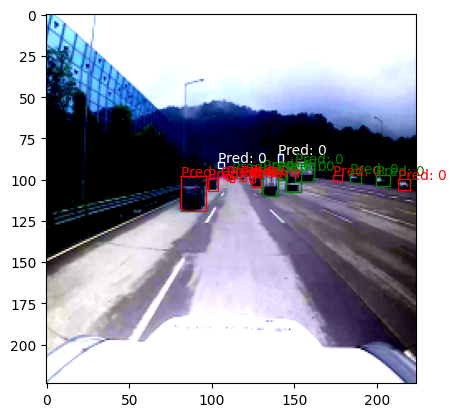

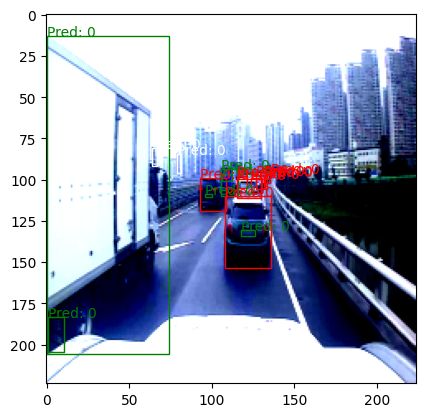

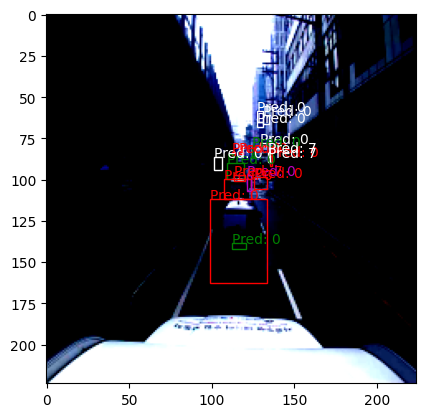

100%|██████████| 25/25 [00:11<00:00,  2.14it/s]


In [217]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Visualization function
def plot_image_with_boxes(img, boxes, labels, preds=None):
    fig, ax = plt.subplots(1)
    ax.imshow(img.permute(1, 2, 0).cpu().numpy())  # Assumes img is a PyTorch tensor with shape (C, H, W)

    colors = ['r', 'g', 'b', 'y', 'm', 'c', 'k', 'w']

    for idx, box in enumerate(boxes):
        label = labels[idx]
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor=colors[label % len(colors)], facecolor='none')
        ax.add_patch(rect)
        if preds is not None:
            ax.text(box[0], box[1], f"Pred: {preds[idx]}", color=colors[label % len(colors)])

    plt.show()

samples_shown = 0
max_samples_to_show = 3

extended_grcnn.eval()  # Set the model to evaluation mode

with torch.no_grad():
    test_loop = tqdm(test_loader, total=len(test_loader), leave=True)
    for batch_data in test_loop:
        inputs = batch_data['data'].to(device)
        bbox_coords_list = []
        labels_list = []

        # Iterate through each sample in the batch_data
        for sample_labels in batch_data['labels']:
            bbox_coords = sample_labels['boxes']
            bbox_coords_list.append(bbox_coords)
            labels_list.append(sample_labels['labels'])

        outputs = extended_grcnn(inputs)

        if samples_shown < max_samples_to_show:
            for i in range(inputs.shape[0]):  # Iterating over batch samples
                if samples_shown < max_samples_to_show:
                    # Assuming bbox_coords_list contains coordinates as [x1, y1, x2, y2]
                    boxes = bbox_coords_list[i].numpy()
                    labels = labels_list[i].numpy()
                    preds = outputs['class_probs'][i].argmax(dim=-1).cpu().numpy()
                    plot_image_with_boxes(inputs[i], boxes, labels, preds)
                    samples_shown += 1
